In [1]:
import random
import numpy as np
import sys
import os
import pandas as pd

In [2]:
# Disable GPU (doesn't work for LSTMs)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import tensorflow

In [4]:
import keras
from keras.models import Model, Input, load_model, Sequential
from keras.layers import Masking, Flatten, Embedding, Dense, LSTM, TimeDistributed, Reshape, multiply, Permute, Lambda
from keras.optimizers import RMSprop, Adam

Using TensorFlow backend.


In [5]:
X_train_no_mask = np.array([[[random.randrange(0,10), 1] for y in range(random.randrange(1,10))] for x in range(1000)])
X_train = np.array([x + [[0, 0]] * (10 - len(x)) for x in X_train_no_mask]) # pad to 10

In [6]:
X_train.shape

(1000, 10, 2)

In [7]:
Y_train = np.array([np.sum(x) for x in X_train])

In [8]:
X_test_no_mask = np.array([[[random.randrange(0,10), 1] for y in range(random.randrange(1,10))] for x in range(1000)])
X_test = np.array([x + [[0, 0]] * (10 - len(x)) for x in X_test_no_mask]) # pad to 10

In [9]:
X_test.shape

(1000, 10, 2)

In [10]:
Y_test = np.array([np.sum(x) for x in X_test])

In [11]:
lstm_units = 128

In [12]:
num_features = X_test.shape[-1]

In [13]:
input_layer = Input(shape=(None, num_features)) 

# set states going into this LSTM application
# in order to use SHAP, need to pass on state
feedin_previous_output = Input(shape=(lstm_units)) 
feedin_cell_state = Input(shape=(lstm_units)) 

x = Masking(mask_value=0)(input_layer)
# x = input_layer
x = LSTM(lstm_units, return_state=True)(x, initial_state=[feedin_previous_output, feedin_cell_state])

# get output from LSTM
output = Lambda(lambda x: x[0])(x)
output = Dense(1)(output) # binary output

# as well as the model output, we want the hidden state output and the cell
# state for later. 
# See https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
lstm_output = Lambda(lambda x: x[0])(x)
cell_state = Lambda(lambda x: x[2])(x)

model = Model(inputs=[input_layer, feedin_previous_output, feedin_cell_state],
              outputs=[output, lstm_output, cell_state])

In [14]:
model.summary()

optimizer = Adam(lr=0.0005, epsilon=1e-08)
# only optimize output from dense layer
model.compile(optimizer, loss=['mean_squared_error', None, None], metrics=['acc'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 2)      0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
______________________________________________________________________________________________

In [15]:
def model_predict(x, h=None, c=None, state=False):
    """Wrapper function for running model predictions. 
    
    h: Input to the model, corresponds with `feedin_previous_output`.
        Set to None for default initialization
        
    c: Input to the model, corresponds with `feedin_cell_state`.
        Set to None for default initialization
        
    state: If True, return the state from the model. Otherwise, just return output.
    
    Returns: model output
    """
    
    if h is None:
        h = np.zeros((len(x), lstm_units))
        
    if c is None:
        c = np.zeros((len(x), lstm_units))

    if state:
        return model.predict([x, h, c])
    return model.predict([x, h, c])[0]

def model_evaluate(x, y):
    """Wrapper function to evaluate model accuracy on x and y. Returns loss."""
    
    return model.evaluate(x=[x, np.zeros((len(x), lstm_units)), np.zeros((len(x), lstm_units))],
                          y=y, verbose=False)[1]

In [16]:
model.fit(x=[X_train, np.zeros((len(X_train), lstm_units)), np.zeros((len(X_train), lstm_units))],
          y=Y_train, epochs=100)

Epoch 1/100
32/32 [==============================] - 0s 8ms/step - loss: 835.8192 - dense_loss: 835.8192 - dense_acc: 0.0000e+00 - lambda_1_acc: 0.0020 - lambda_2_acc: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 515.0194 - dense_loss: 515.0194 - dense_acc: 0.0000e+00 - lambda_1_acc: 0.0170 - lambda_2_acc: 0.0000e+00
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 332.6231 - dense_loss: 332.6231 - dense_acc: 0.0000e+00 - lambda_1_acc: 0.0170 - lambda_2_acc: 0.0000e+00
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 261.8176 - dense_loss: 261.8176 - dense_acc: 0.0000e+00 - lambda_1_acc: 0.0150 - lambda_2_acc: 0.0000e+00
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 218.2455 - dense_loss: 218.2455 - dense_acc: 0.0000e+00 - lambda_1_acc: 0.0130 - lambda_2_acc: 0.0000e+00
Epoch 6/100
32/32 [==============================] - 0s 7ms/step - loss: 186.9227 - dense_loss: 186.9227 

32/32 [==============================] - 0s 6ms/step - loss: 0.9375 - dense_loss: 0.9375 - dense_acc: 0.0130 - lambda_1_acc: 0.0000e+00 - lambda_2_acc: 0.0000e+00
Epoch 94/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7363 - dense_loss: 0.7363 - dense_acc: 0.0130 - lambda_1_acc: 0.0000e+00 - lambda_2_acc: 0.0000e+00
Epoch 95/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7166 - dense_loss: 0.7166 - dense_acc: 0.0130 - lambda_1_acc: 0.0000e+00 - lambda_2_acc: 0.0000e+00
Epoch 96/100
32/32 [==============================] - 0s 7ms/step - loss: 0.6917 - dense_loss: 0.6917 - dense_acc: 0.0130 - lambda_1_acc: 0.0000e+00 - lambda_2_acc: 0.0000e+00
Epoch 97/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7340 - dense_loss: 0.7340 - dense_acc: 0.0130 - lambda_1_acc: 0.0000e+00 - lambda_2_acc: 0.0000e+00
Epoch 98/100
32/32 [==============================] - 0s 6ms/step - loss: 0.6515 - dense_loss: 0.6515 - dense_acc: 0.0130 - lambda_1_

In [17]:
model_evaluate(X_train, Y_train)

0.6614947319030762

In [18]:
model_predict(X_train[4:5])

array([[22.018776]], dtype=float32)

In [19]:
X_train[4:5]

array([[[8, 1],
        [7, 1],
        [4, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]]])

In [20]:
np.sum(X_train[4:5])

22

In [21]:
Y_train[4]

22

In [22]:
model_evaluate(X_test,Y_test)

0.8976387977600098

## Old SHAP

In [23]:
sys.path.append(os.path.join('../..', 'shap'))
import shap as shap

shap.initjs()

In [24]:
def predict(X, **kwargs):
    X = X.reshape((-1,1,num_features))
    return model_predict(X).flatten()

In [25]:
flatten = lambda lst: np.array([x for y in lst for x in y])

In [26]:
all_data = flatten(X_test_no_mask) # X_test_no_mask

In [27]:
all_data.shape

(5078, 2)

In [28]:
all_data_summary = shap.kmeans(all_data, 9)

In [29]:
%%time
explainer = shap.KernelExplainer(predict, all_data_summary)
shap_values = explainer.shap_values(all_data)


Wall time: 1min 40s


In [30]:
explainer.expected_value

8.895268440246582

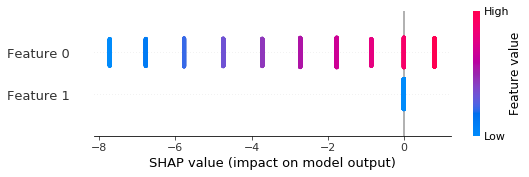

In [31]:
shap.summary_plot(shap_values, all_data)

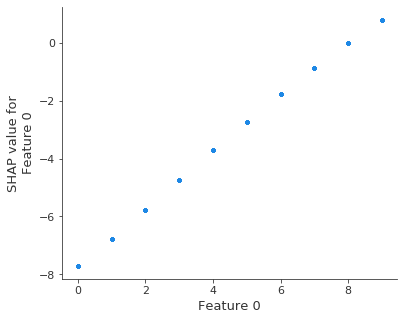

In [32]:
shap.dependence_plot(0, shap_values, features=all_data, interaction_index=None)

In [33]:
sequence_indices = []
temp = 0
for x in [len(x) for x in X_test_no_mask]: # X_test_no_mask
    sequence_indices.append((temp, x+temp))
    temp += x

In [34]:
sl = slice(*sequence_indices[1])
print(all_data[sl])
print(shap_values[sl])
shap.force_plot(explainer.expected_value, shap_values[sl], all_data[sl])

[[1 1]
 [7 1]
 [8 1]
 [6 1]
 [8 1]]
[[-6.77450824e+00  0.00000000e+00]
 [-8.55863571e-01  0.00000000e+00]
 [ 9.53674316e-07  0.00000000e+00]
 [-1.76394272e+00  0.00000000e+00]
 [ 9.53674316e-07  0.00000000e+00]]


## New SHAP

In [35]:
def state_predict(X, internal_state=None):
    """
    internal_state: list of internal states. should be of the form [h, c]
    
    Returns [output, h, c]
    """
    X = X.reshape((-1,1,num_features))
    
    if internal_state:
        h,c = internal_state
        o, nh, nc = model_predict(X, h=h, c=c, state=True)
        return o.flatten(), nh, nc

    o, nh, nc = model_predict(X, state=True)
    return o.flatten(), nh, nc

In [36]:
association = flatten([[i for _ in range(len(x))] for i, x in enumerate(X_test_no_mask)]) # X_test_no_mask

In [37]:
state_explainer = shap.KernelExplainer(state_predict, all_data_summary)
state_shap_values = state_explainer.shap_values(all_data, association=pd.Series(association))

In [38]:
state_explainer.expected_value

5.728865272888944

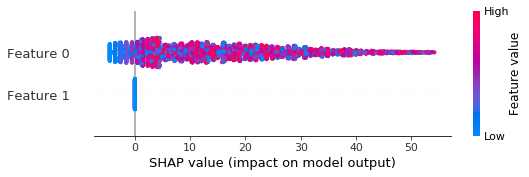

In [39]:
shap.summary_plot(state_shap_values, all_data)

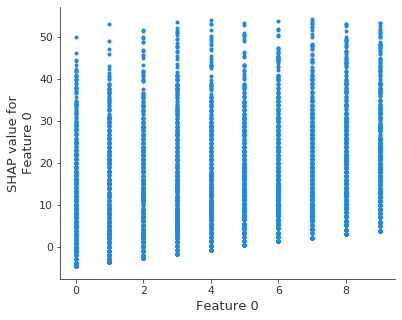

In [40]:
shap.dependence_plot(0, state_shap_values, features=all_data, interaction_index=None)

In [41]:
sl = slice(*sequence_indices[11])
print(all_data[sl])
print(state_shap_values[sl])
shap.force_plot(state_explainer.expected_value, state_shap_values[sl], all_data[sl])

[[8 1]
 [6 1]
 [7 1]
 [2 1]
 [5 1]]
[[ 3.16640412  0.        ]
 [10.40072762  0.        ]
 [18.14132249  0.        ]
 [21.06127106  0.        ]
 [26.89996468  0.        ]]


## Local accuracy

The model evaluates all elements in the sequence and outputs a single number (the sum of all time series). However, SHAP calculates a shap value for every time step within all sequence. To check if the model output is the same as from SHAP, the last element in the sequence is used. 

`allclose` is used due to floating point accuracy limitations.

In [42]:
preds = model_predict(X_test).flatten()

### Old SHAP

In [43]:
np.allclose([shap_values[slice(*sl)][-1].sum() + explainer.expected_value for sl in sequence_indices], preds)

False

### New SHAP

In [44]:
np.allclose([state_shap_values[slice(*sl)][-1].sum() + state_explainer.expected_value for sl in sequence_indices], preds)

True

## Missingness

LSTMs have some added difficulty in that missing features can be used by the model (e.g. for a model that counts the number of input time steps) and it would be impossible to satisfy this and local accuracy for the addition model. To get around this, a new feature can be made that extracts the importance from the previous application.

However, the notion of missingness doesn't make sense for time series models. For instance, consider a counter model that counts the number of inputs the model has seen.

In [45]:
Y_test[11]

33

In [46]:
preds[11]

32.62883

In [47]:
X_test[11:12]

array([[[8, 1],
        [6, 1],
        [7, 1],
        [2, 1],
        [5, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]]])

In [59]:
[model_predict(X_test[11:12,:x])[0][0] for x in range(1, 11)]

[8.895269,
 16.129593,
 23.870188,
 26.790136,
 32.62883,
 32.62883,
 32.62883,
 32.62883,
 32.62883,
 32.62883]

In [49]:
state_shap_values[slice(*sequence_indices[11])]

array([[ 3.16640412,  0.        ],
       [10.40072762,  0.        ],
       [18.14132249,  0.        ],
       [21.06127106,  0.        ],
       [26.89996468,  0.        ]])

## new shap values with offset

In [50]:
new_shap_values = []
for sl in sequence_indices:
    prev_features = None
    for features in state_shap_values[slice(*sl)]:
        if prev_features is None:
            new_shap_values.append([*features, 0])
        else:
            new_shap_values.append([*(features - prev_features), sum(prev_features)])
        prev_features = features
new_shap_values = np.array(new_shap_values)

In [51]:
new_shap_values

array([[ 3.16640412,  0.        ,  0.        ],
       [ 3.0727396 ,  0.        ,  3.16640412],
       [ 6.90104961,  0.        ,  6.23914372],
       ...,
       [-3.60810507,  0.        ,  0.        ],
       [ 9.63635993,  0.        , -3.60810507],
       [ 8.0584507 ,  0.        ,  6.02825486]])

In [52]:
new_shap_values[slice(*sequence_indices[11])]

array([[ 3.16640412,  0.        ,  0.        ],
       [ 7.2343235 ,  0.        ,  3.16640412],
       [ 7.74059486,  0.        , 10.40072762],
       [ 2.91994858,  0.        , 18.14132249],
       [ 5.83869362,  0.        , 21.06127106]])

In [53]:
# local
np.allclose([new_shap_values[slice(*sl)][-1].sum() + state_explainer.expected_value for sl in sequence_indices], preds)

True

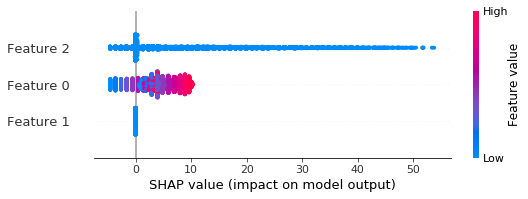

In [54]:
shap.summary_plot(new_shap_values, np.c_[all_data, np.zeros(len(all_data))])

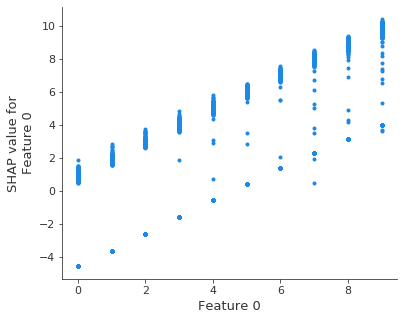

In [55]:
shap.dependence_plot(0, new_shap_values, features=np.c_[all_data, np.zeros(len(all_data))], interaction_index=None)

In [89]:
sl = slice(*sequence_indices[11])
print(all_data[sl])
print(new_shap_values[sl])
shap.force_plot(explainer.expected_value, new_shap_values[sl], np.c_[all_data, np.zeros(len(all_data))][sl])

[[8 1]
 [6 1]
 [7 1]
 [2 1]
 [5 1]]
[[ 3.16640412  0.          0.        ]
 [ 7.2343235   0.          3.16640412]
 [ 7.74059486  0.         10.40072762]
 [ 2.91994858  0.         18.14132249]
 [ 5.83869362  0.         21.06127106]]


## new shap values with offset v2

Instead of the above, how about using normal SHAP but getting a `previous state` score?

E.g. sometimes the LSTM bases it's predictions from something other than the features. For example, a counter model.

In [61]:
explainer.expected_value

8.895268440246582

In [81]:
offset_shap_values = np.c_[shap_values, state_shap_values.sum(axis=1) + state_explainer.expected_value - (
    shap_values.sum(axis=1) + explainer.expected_value)]

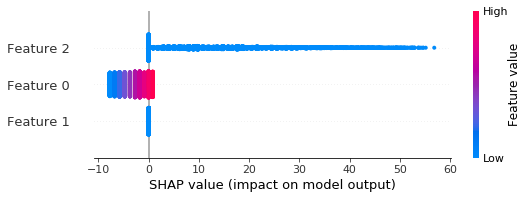

In [83]:
shap.summary_plot(offset_shap_values, np.c_[all_data, np.zeros(len(all_data))])

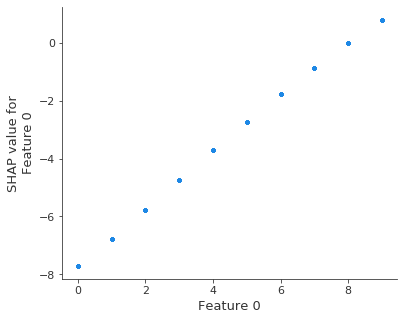

In [82]:
shap.dependence_plot(0, offset_shap_values, features=np.c_[all_data, np.zeros(len(all_data))], interaction_index=None)

In [88]:
sl = slice(*sequence_indices[11])
print(all_data[sl])
print(offset_shap_values[sl])
shap.force_plot(explainer.expected_value, offset_shap_values[sl], np.c_[all_data, np.zeros(len(all_data))][sl])

[[8 1]
 [6 1]
 [7 1]
 [2 1]
 [5 1]]
[[ 9.53674316e-07  0.00000000e+00  0.00000000e+00]
 [-1.76394272e+00  0.00000000e+00  8.99826717e+00]
 [-8.55863571e-01  0.00000000e+00  1.58307829e+01]
 [-5.77089572e+00  0.00000000e+00  2.36657636e+01]
 [-2.72079229e+00  0.00000000e+00  2.64543538e+01]]
